In [61]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


https://www.kaggle.com/tanulsingh077/end-to-end-object-detection-with-transformers-detr?select=train.csv

In [62]:
import pandas as pd
import numpy as np 

marking = pd.read_csv('/content/gdrive/MyDrive/kaggle/wheat_detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)
marking

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0


In [63]:
cd /content/gdrive/MyDrive/kaggle/detr

/content/gdrive/MyDrive/kaggle/detr


In [64]:
! pip install albumentations==0.4.6

In [65]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
#################################################################


#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
#from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

In [66]:
n_folds = 5
seed = 42
num_classes = 2
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 8
LR = 2e-5
EPOCHS = 10

In [67]:
# Creating Folds
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [68]:
print(df_folds.columns)
df_folds

Index(['bbox_count', 'source', 'stratify_group', 'fold'], dtype='object')


,bbox_count,source,stratify_group,fold
image_id,,,,
00333207f,55,arvalis_1,arvalis_1_3,1
005b0d8bb,20,usask_1,usask_1_1,3
006a994f7,25,inrae_1,inrae_1_1,1
00764ad5d,41,inrae_1,inrae_1_2,0
00b5fefed,25,arvalis_3,arvalis_3_1,3
...,...,...,...,...
ffb445410,57,rres_1,rres_1_3,1
ffbf75e5b,52,arvalis_1,arvalis_1_3,1
ffbfe7cc0,34,arvalis_1,arvalis_1_2,3


In [69]:
df_folds['stratify_group'].value_counts()

arvalis_1_2    495
ethz_1_4       364
arvalis_1_3    346
ethz_1_5       214
rres_1_3       172
arvalis_2_1    171
arvalis_3_1    160
arvalis_3_0    154
rres_1_2       145
ethz_1_3       141
inrae_1_1      127
arvalis_1_1    115
arvalis_3_3    104
arvalis_3_2     94
usask_1_1       93
usask_1_2       81
rres_1_4        75
arvalis_1_4     70
arvalis_3_4     40
rres_1_1        39
inrae_1_0       31
arvalis_2_0     26
arvalis_1_5     23
inrae_1_2       18
ethz_1_6        18
usask_1_3       15
usask_1_0       11
ethz_1_2         8
arvalis_2_2      7
arvalis_3_5      7
arvalis_1_6      5
ethz_1_7         2
rres_1_5         1
arvalis_1_0      1
Name: stratify_group, dtype: int64

In [70]:
df_folds['fold'].value_counts()

1    675
2    675
0    675
3    674
4    674
Name: fold, dtype: int64

In [71]:
def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
                               
                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),
                      
                      A.ToGray(p=0.01),
                      
                      A.HorizontalFlip(p=0.5),
                      
                      A.VerticalFlip(p=0.5),
                      
                      A.Resize(height=512, width=512, p=1),
                      
                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, p=0.5),
                      
                      ToTensorV2(p=1.0)],
                      
                      p=1.0,
                     
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

In [72]:
DIR_TRAIN = '/content/gdrive/MyDrive/kaggle/wheat_detection/dataset/train'

class WheatDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = records[['x', 'y', 'w', 'h']].values
        
        #Area of bb
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels =  np.zeros(len(boxes), dtype=np.int32)
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
            
            
        #Normalizing BBOXES
            
        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id

In [73]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [74]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

In [75]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
"""
Train and eval functions used in main.py
"""
import math
import os
import sys
from typing import Iterable

import torch

import util.misc as utils
from datasets.coco_eval import CocoEvaluator
from datasets.panoptic_eval import PanopticEvaluator


def train_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,
                    data_loader: Iterable, optimizer: torch.optim.Optimizer,
                    device: torch.device, epoch: int, max_norm: float = 0):
    model.train()
    criterion.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    metric_logger.add_meter('class_error', utils.SmoothedValue(window_size=1, fmt='{value:.2f}'))
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 10

    for samples, targets in metric_logger.log_every(data_loader, print_freq, header):
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(samples)
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                      for k, v in loss_dict_reduced.items()}
        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
        losses_reduced_scaled = sum(loss_dict_reduced_scaled.values())

        loss_value = losses_reduced_scaled.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        metric_logger.update(loss=loss_value, **loss_dict_reduced_scaled, **loss_dict_reduced_unscaled)
        metric_logger.update(class_error=loss_dict_reduced['class_error'])
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}


@torch.no_grad()
def evaluate(model, criterion, postprocessors, data_loader, base_ds, device, output_dir):
    model.eval()
    criterion.eval()

    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('class_error', utils.SmoothedValue(window_size=1, fmt='{value:.2f}'))
    header = 'Test:'

    iou_types = tuple(k for k in ('segm', 'bbox') if k in postprocessors.keys())
    coco_evaluator = CocoEvaluator(base_ds, iou_types)
    # coco_evaluator.coco_eval[iou_types[0]].params.iouThrs = [0, 0.1, 0.5, 0.75]

    panoptic_evaluator = None
    if 'panoptic' in postprocessors.keys():
        panoptic_evaluator = PanopticEvaluator(
            data_loader.dataset.ann_file,
            data_loader.dataset.ann_folder,
            output_dir=os.path.join(output_dir, "panoptic_eval"),
        )

    for samples, targets in metric_logger.log_every(data_loader, 10, header):
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(samples)
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                      for k, v in loss_dict_reduced.items()}
        metric_logger.update(loss=sum(loss_dict_reduced_scaled.values()),
                             **loss_dict_reduced_scaled,
                             **loss_dict_reduced_unscaled)
        metric_logger.update(class_error=loss_dict_reduced['class_error'])

        orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)
        results = postprocessors['bbox'](outputs, orig_target_sizes)
        if 'segm' in postprocessors.keys():
            target_sizes = torch.stack([t["size"] for t in targets], dim=0)
            results = postprocessors['segm'](results, outputs, orig_target_sizes, target_sizes)
        res = {target['image_id'].item(): output for target, output in zip(targets, results)}
        if coco_evaluator is not None:
            coco_evaluator.update(res)

        if panoptic_evaluator is not None:
            res_pano = postprocessors["panoptic"](outputs, target_sizes, orig_target_sizes)
            for i, target in enumerate(targets):
                image_id = target["image_id"].item()
                file_name = f"{image_id:012d}.png"
                res_pano[i]["image_id"] = image_id
                res_pano[i]["file_name"] = file_name

            panoptic_evaluator.update(res_pano)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    if coco_evaluator is not None:
        coco_evaluator.synchronize_between_processes()
    if panoptic_evaluator is not None:
        panoptic_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    if coco_evaluator is not None:
        coco_evaluator.accumulate()
        coco_evaluator.summarize()
    panoptic_res = None
    if panoptic_evaluator is not None:
        panoptic_res = panoptic_evaluator.summarize()
    stats = {k: meter.global_avg for k, meter in metric_logger.meters.items()}
    if coco_evaluator is not None:
        if 'bbox' in postprocessors.keys():
            stats['coco_eval_bbox'] = coco_evaluator.coco_eval['bbox'].stats.tolist()
        if 'segm' in postprocessors.keys():
            stats['coco_eval_masks'] = coco_evaluator.coco_eval['segm'].stats.tolist()
    if panoptic_res is not None:
        stats['PQ_all'] = panoptic_res["All"]
        stats['PQ_th'] = panoptic_res["Things"]
        stats['PQ_st'] = panoptic_res["Stuff"]
    return stats, coco_evaluator


In [76]:
matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

In [77]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    
    summary_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        output = model(images)


        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)
        
    return summary_loss

In [78]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss

In [79]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [80]:
def run(fold):
    
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]
    
    train_dataset = WheatDataset(
    image_ids=df_train.index.values,
    dataframe=marking,
    transforms=get_train_transforms()
    )

    valid_dataset = WheatDataset(
    image_ids=df_valid.index.values,
    dataframe=marking,
    transforms=get_valid_transforms()
    )
    
    train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )
    
    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model = model.to(device)
    criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)
    

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    
    best_loss = 10**5
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model,criterion, device)
        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))
        
        print(f'valid_loss {valid_loss}')
        print(f'valid_loss.avg {valid_loss.avg}')
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'/content/gdrive/MyDrive/kaggle/wheat_detection/model/detr_best_{fold}.pth')
            

In [ ]:
run(fold=3)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


KeyboardInterrupt: ignored

In [81]:
def view_sample(df_valid,model,device):
    '''
    Code taken from Peter's Kernel 
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''
    valid_dataset = WheatDataset(image_ids=df_valid.index.values,
                                 dataframe=marking,
                                 transforms=get_valid_transforms()
                                )
     
    valid_data_loader = DataLoader(
                                    valid_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                   num_workers=4,
                                   collate_fn=collate_fn)
    
    images, targets, image_ids = next(iter(valid_data_loader))
    _,h,w = images[0].shape # for de normalizing images
    
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes = targets[0]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]

    true = images[0].permute(1,2,0).cpu().numpy()
    predict = true.copy()

    
    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad():
        outputs = model(images)
        
    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    for box in boxes:   # real
        cv2.rectangle(true,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 2)
        

    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    
    for box,p in zip(oboxes,prob):    # predict
        # print(f'box {box}')
        # print(f'p {p}')
        if p >0.9:
            color = (0,0,255)
            cv2.rectangle(predict,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  color, 2)
       
    
    ax[0].set_axis_off()
    ax[0].imshow(true)
    ax[1].set_axis_off()
    ax[1].imshow(predict)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


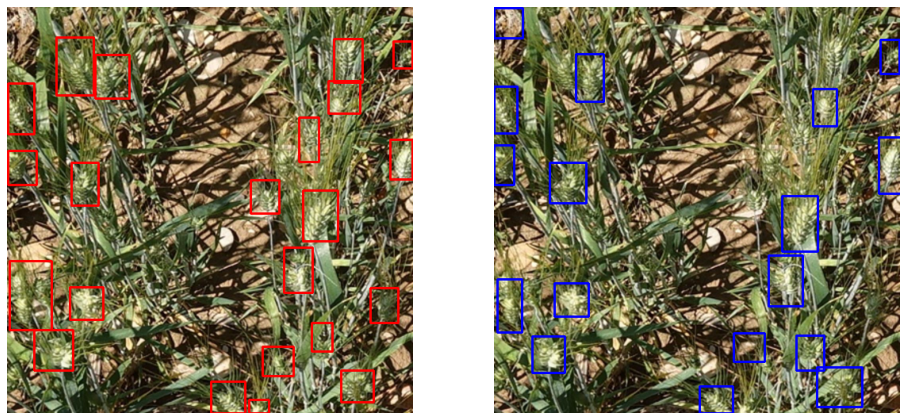

In [82]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("/content/gdrive/MyDrive/kaggle/wheat_detection/model/detr_best_0.pth"))
view_sample(df_folds[df_folds['fold'] == 1],model=model,device=torch.device('cuda'))